In [14]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import matplotlib

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [15]:
# write your code here
# Establish a connection to the SQLite database
conn = sqlite3.connect("../db.sqlite3")

# Formulate SQL query to retrieve relevant data from the database
query = ("SELECT * FROM restaurant_orderitem"
         " JOIN restaurant_product ON restaurant_orderitem.product_id = restaurant_product.id"
         " JOIN restaurant_order ON restaurant_orderitem.order_id = restaurant_order.id")

# Read data from the database using the SQL query and connection
df = pd.read_sql_query(query, conn)

# Select only necessary columns from the DataFrame
df = df[["order_id","datetime", "product_id", "name", "price", "quantity"]]

# Rename columns for better readability
df = df.rename(columns={"datetime": "order_datetime", "name": "product_name", "price": "product_price"})

# Save the DataFrame to a CSV file without including the index
df.to_csv("restaurant.csv", index=False)

# Read the saved CSV file into a DataFrame
df = pd.read_csv("restaurant.csv")

len(df) # should be 74818 rows in the DataFrame

74818

# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

<Axes: title={'center': 'Top 10 most popular products in restaurant sold by Quantity'}>

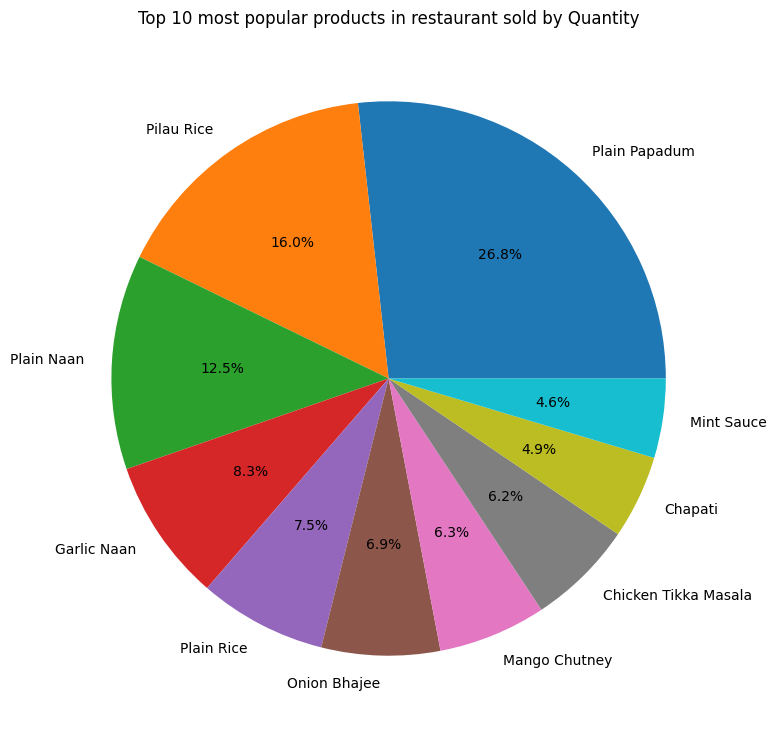

In [16]:
# write your code here

top_10_products = (df["quantity"]  # Extract the 'quantity' column from the DataFrame
                   .groupby(df["product_name"])  # Group by product name
                   .sum()  # summing up the quantities sold for each product
                   .sort_values(ascending=False)  # sort by total quantity sold in descending 
                   .head(10)  #  top 10
                   )

# Plotting a pie chart for the top 10 most popular products by quantity sold
(top_10_products
 .plot  # Use the plot attribute to access plotting methods
 .pie(title="Top 10 most popular products in restaurant sold by Quantity",  # Set title for the pie chart
      figsize=(9, 9),  # Set the size of the figure (plot)
      label="",  # Do not display labels on the pie chart
      autopct="%1.1f%%", )  # Display percentages on each 
 )  # wedge with one decimal place

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

<Axes: title={'center': 'Top 10 products by money made'}>

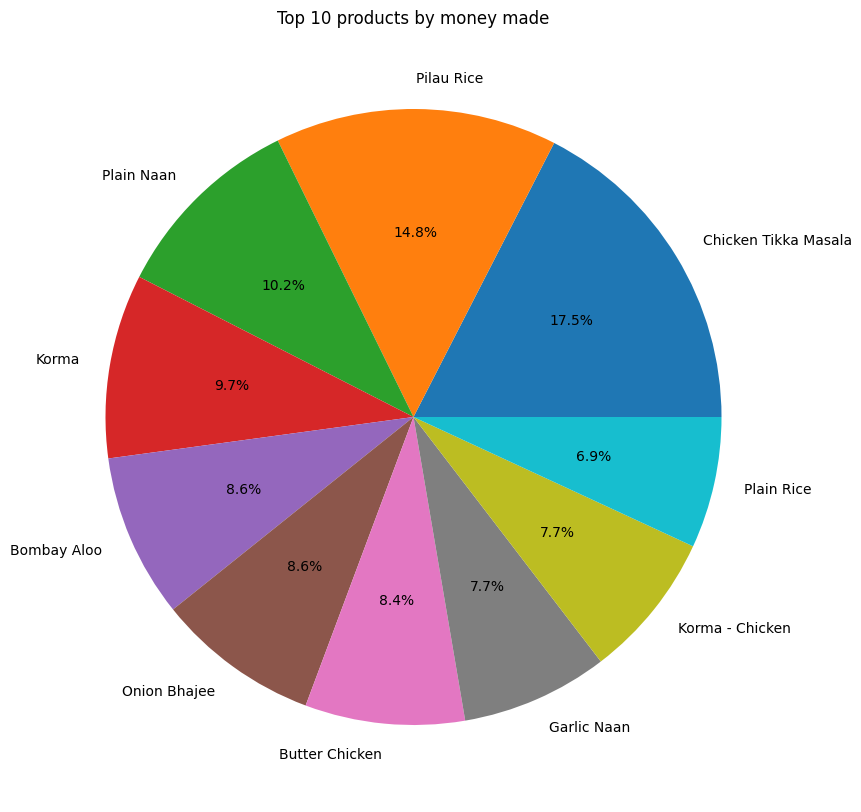

In [17]:
# write your code here
# Calculate item price for each order item by multiplying product price with quantity sold
df["item_price"] = df["product_price"] * df["quantity"]

top_items = (df["item_price"]
             .groupby(df["product_name"])  # Group the data by product name
             .sum()  # summing up the item prices for each product
             .sort_values(ascending=False)  # sort them by the total item price in descending order
             .head(10)  # select the top 10
             )
# Plotting a pie chart to visualize the top 10 products by the money made
(top_items
 .plot  # Accessing the plot attribute to access plotting methods
 .pie(title="Top 10 products by money made",  # Set title for the pie chart
      figsize=(10, 10),  # Set the size of the figure (plot)
      label="",  # Do not display labels on the pie chart
      autopct="%1.1f%%")  # Display percentages on each wedge with one decimal place
 )

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

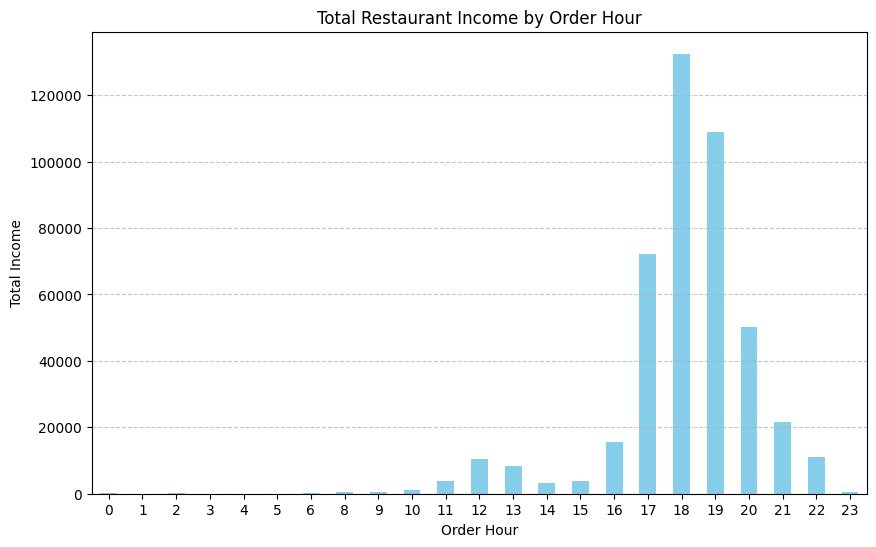

In [20]:
# write your code here
# Convert 'order_datetime' to datetime format, extract the hour component, and calculate the total sum of order prices for each hour
hourly_income = (df
                 .assign(Order_Hour=pd.to_datetime(df['order_datetime']).dt.hour)
                 .groupby('Order_Hour')['item_price']
                 .sum()
                 )

# Plotting a bar chart to visualize the total restaurant income based on the hour order was created
plt.figure(figsize=(10, 6))
hourly_income.plot(kind='bar', color='skyblue')
plt.title('Total Restaurant Income by Order Hour')
plt.xlabel('Order Hour')
plt.ylabel('Total Income')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

<Axes: title={'center': 'Total Restaurant Income by Order Day of the Week'}, xlabel='Day of the week', ylabel='Total Income'>

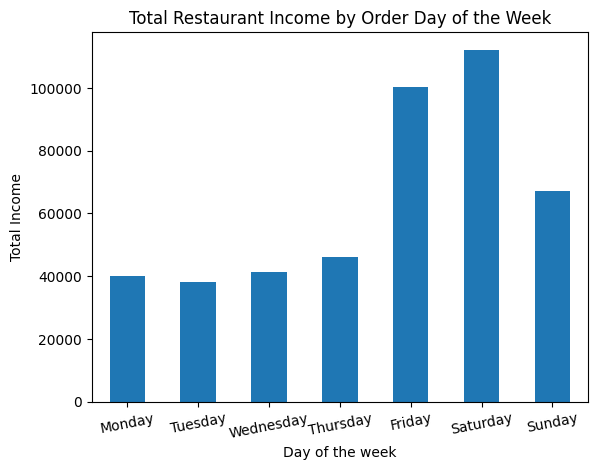

In [25]:
# write your code here
# Extract the day of the week from the 'order_datetime' column using the dt.dayofweek attribute
df["order_day_of_week"] = (df["order_datetime"]
                           .dt  # Access the datetime accessor
                           .dayofweek  # Extract the day of the week component
                           )
# Calculate the total income for each day of the week 
daily_income = (df["item_price"]  # Select the 'item_price' column
                .groupby(df["order_day_of_week"])  # Group by the 'order_day_of_week' column
                .sum()  # Sum up the 'item_price' for each group
                )
# Rename the index to reflect the actual names of the days of the week
daily_income.index = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
# Plotting a bar chart to visualize the total restaurant income based on the day of the week order was created
(daily_income
 .plot
 .bar(title="Total Restaurant Income by Order Day of the Week",  # Set title for the bar chart
      xlabel="Day of the week",  # Set label for x-axis
      ylabel="Total Income",  # Set label for y-axis
      rot=11)  # Rotate x-axis labels for better readability
 )